In [1]:
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip -n -qq '/content/gdrive/My Drive/Oxford dataset.zip'
# !ls 'images'
!ls 'annotations'

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [4]:
with open('annotations/README', 'r') as file:
  print(file.read())

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

In [5]:
import os

file_names = os.listdir('images')

for file_name in file_names:
  if file_name[0].isupper():
    file_path = os.path.join('images', file_name)
    try:
      os.remove(file_path)
      # print(f"Deleted: {file_path}")
    except Exception as e:
      print(f"Error deleting {file_path}: {e}")

for file_name in file_names:
  if file_name.endswith(".mat"):
    file_path = os.path.join('images', file_name)
    try:
      os.remove(file_path)
      # print(f"Deleted: {file_path}")
    except Exception as e:
      print(f"Error deleting {file_path}: {e}")

Error deleting images/Abyssinian_100.mat: [Errno 2] No such file or directory: 'images/Abyssinian_100.mat'
Error deleting images/Abyssinian_101.mat: [Errno 2] No such file or directory: 'images/Abyssinian_101.mat'
Error deleting images/Abyssinian_102.mat: [Errno 2] No such file or directory: 'images/Abyssinian_102.mat'


In [6]:
import shutil

def delete_folder(folder_path):
    try:
        # Delete the folder and its contents
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' successfully deleted.")
    except Exception as e:
        print(f"Error deleting folder '{folder_path}': {e}")

In [7]:
delete_folder('dogImages')
delete_folder('images_new')

Folder 'dogImages' successfully deleted.
Folder 'images_new' successfully deleted.


In [8]:
!ls

annotations  gdrive  images  model_scratch.pt  sample_data


In [9]:
import os
import shutil
import re

def extract_breed_name(filename):
    match = re.match(r'^(.*?[^_])_\d', filename)
    if match:
        return match.group(1)
    else:
        return filename

def organize_images_by_breed(source_folder, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)

    for filename in os.listdir(source_folder):
        if not os.path.isfile(os.path.join(source_folder, filename)):
            continue

        breed_name = extract_breed_name(filename)
        breed_folder = os.path.join(destination_folder, breed_name)
        os.makedirs(breed_folder, exist_ok=True)

        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(breed_folder, filename)
        shutil.move(source_path, destination_path)

In [10]:
organize_images_by_breed("images", "images_new")

In [11]:
import os
import shutil
import random

original_folder_path = "images_new"
new_folder_path = "dogImages"

In [12]:
for subset in ['train', 'valid', 'test']:
    subset_path = os.path.join(new_folder_path, subset)
    os.makedirs(subset_path, exist_ok=True)

train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# ratio = [0, train_ratio, valid_ratio, test_ratio]

for breed_folder in os.listdir(original_folder_path):
    breed_path = os.path.join(original_folder_path, breed_folder)

    if not os.path.isdir(breed_path):
      continue

    image_files = [f for f in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, f))]

    random.shuffle(image_files)
    num_images = len(image_files)
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    num_test = num_images - num_train - num_valid
    nums = [0, num_train, num_valid, num_test]

    for i, subset in enumerate(['x', 'train', 'valid', 'test']):
      if i == 0:
        continue

      subset_path = os.path.join(new_folder_path, subset, breed_folder)
      os.makedirs(subset_path, exist_ok=True)

      start_index = nums[i-1]
      end_index = nums[i-1] + nums[i]

      subset_files = image_files[start_index:end_index]

      for file in subset_files:
        src_path = os.path.join(breed_path, file)
        dest_path = os.path.join(subset_path, file)

        shutil.copy(src_path, dest_path)

print(os.listdir(new_folder_path))

['test', 'train', 'valid']


In [13]:
# !ls "dogImages/train/american_bulldog"

In [14]:
# !ls "dogImages/test"

In [15]:
# !ls "dogImages/valid"

In [16]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets

# Check cuda availability
use_cuda = torch.cuda.is_available()

# Data preprocess dict
data_preprocess  = {

    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),

    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),

}

In [17]:
path = "dogImages/"

images = {x: datasets.ImageFolder(os.path.join(path, x), data_preprocess[x]) for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(images[x], batch_size = 20, shuffle = True, num_workers = 0) for x in ['train', 'valid', 'test']}

sizes = {x: len(images[x]) for x in ['train', 'valid', 'test']}

print('Train images: {}'.format(sizes['train']))
print('Valid images: {}'.format(sizes['valid']))
print('Test images: {}'.format(sizes['test']))

Train images: 3492
Valid images: 747
Test images: 751


In [19]:
names = images['train'].classes
clean_names = []
# print(names)

for name in names:
    clean_names.append(name[:].replace('_', ' '))

n_classes = len(clean_names)
print("Number of classes:",n_classes)

for i in range(5):
    print (clean_names[i])

Number of classes: 25
american bulldog
american pit bull terrier
basset hound
beagle
boxer


In [20]:
import matplotlib.pyplot as plt
import torchvision

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.7)

        self.fc1 = nn.Linear(256*7*7, 512)
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))

        x = self.conv_bn6(x)

        x = x.view(-1, 256 * 7 * 7)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv_bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv_bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv_bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, n_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv_bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv_bn2(self.conv2(x))))
        x = self.pool(F.relu(self.conv_bn3(self.conv3(x))))

        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model_scratch = Net2()

if use_cuda:
    model_scratch.cuda()

In [41]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay = 1e-3)
# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
# scheduler_scratch = ReduceLROnPlateau(optimizer_scratch, mode='min', patience=10, factor=0.5, verbose=True, min_lr=1e-8)
scheduler_scratch = ReduceLROnPlateau(optimizer_scratch, mode='min', patience=5, factor=0.1, verbose=True)


In [42]:
from PIL import ImageFile
import time
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path):
    """returns trained model"""
    since = time.time()
    valid_loss_min = np.Inf
    train_losses = []
    valid_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

        scheduler.step(valid_loss)  # Adjust learning rate based on validation loss

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
        ))
        train_losses.append(train_loss.item())
        valid_losses.append(valid_loss.item())

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            print('Validation Loss decreased! Model saved.')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    plt.plot(np.arange(1, n_epochs + 1), train_losses, label='Training Loss')
    plt.plot(np.arange(1, n_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, train_losses, valid_losses

In [24]:
loaders_scratch = dataloaders
model_scratch, train_scratch, valid_scratch = train(500, loaders_scratch, model_scratch, optimizer_scratch, scheduler_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 6.772011 	Validation Loss: 3.218476
Validation Loss decreased! Model saved.
Epoch: 2 	Training Loss: 3.228026 	Validation Loss: 3.213779
Validation Loss decreased! Model saved.
Epoch: 3 	Training Loss: 3.220763 	Validation Loss: 3.218970
Epoch: 4 	Training Loss: 3.219385 	Validation Loss: 3.219014
Epoch: 5 	Training Loss: 3.219619 	Validation Loss: 3.218952
Epoch: 6 	Training Loss: 3.219775 	Validation Loss: 3.219216
Epoch: 7 	Training Loss: 3.219878 	Validation Loss: 3.219040
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 8 	Training Loss: 3.224250 	Validation Loss: 3.218060
Epoch: 9 	Training Loss: 3.219384 	Validation Loss: 3.218807
Epoch: 10 	Training Loss: 3.218852 	Validation Loss: 3.218924
Epoch: 11 	Training Loss: 3.217577 	Validation Loss: 3.192395
Validation Loss decreased! Model saved.
Epoch: 12 	Training Loss: 3.169313 	Validation Loss: 3.132199
Validation Loss decreased! Model saved.
Epoch: 13 	Training Loss: 3.153052 	Validat

KeyboardInterrupt: ignored

In [24]:
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [26]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.941831


Test Accuracy: 76% (572/751)


In [36]:
%pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=7b501eef795cab80804807a307aecbd4e9b20705648b5d0ca98bc3619c3c5f07
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [38]:
%pip install torchsummary

In [47]:
from torchsummary import summary
# model = Net2()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net2().to(device)
summary(model, (3, 224, 224))
# summary(model, (3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Dropout-10               [-1, 100352]               0
           Linear-11                  [-1, 512]      51,380,736
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 25]          12,825
Total params: 51,487,257
Trainable para

In [37]:
import torch
from torchviz import make_dot

model = Net2()

dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)
make_dot(output, params=dict(model.named_parameters())).render('model_graph', format='png')

'model_graph.png'

In [55]:
import matplotlib.image as mpimg
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms

def predict_breed(img_path):
    img = Image.open(img_path)

    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])

    preprocess = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), normalize])

    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)

    if use_cuda:
        img_tensor = img_tensor.cuda()

    model_transfer[0].eval()

    output = model_transfer[0](img_tensor)
    output = output.cpu()

    # Get the prediction index
    predicted_index = output.data.numpy().argmax()

    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    breed = names[predicted_index].replace('_', ' ')
    print("It looks like a {}".format(breed))

    # Returns the predicted class
    return breed

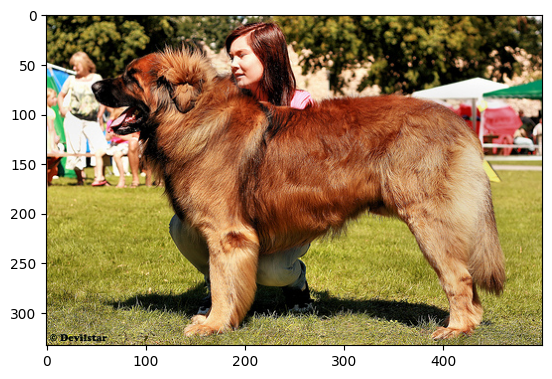

It looks like a leonberger


'leonberger'

In [57]:
predict_breed('/content/dogImages/test/leonberger/leonberger_147.jpg')

In [ ]:
import torchvision.models as models
import torch.nn as nn

In [25]:
n_epochs = 11
learning_rate = 0.001
momentum = 0.9

In [26]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.densenet161(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
num_ftrs = model_transfer.classifier.in_features
model_transfer.classifier = nn.Linear(num_ftrs, n_classes)

if use_cuda:
    model_transfer.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 106MB/s]


In [27]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001, betas=(0.9,0.999))
scheduler_transfer = ReduceLROnPlateau(optimizer_transfer, mode='min', patience=5, factor=0.1, verbose=True)
loaders_transfer = dataloaders

Epoch: 1 	Training Loss: 1.003158 	Validation Loss: 0.328724
Validation Loss decreased! Model saved.
Epoch: 2 	Training Loss: 0.303921 	Validation Loss: 0.228244
Validation Loss decreased! Model saved.
Epoch: 3 	Training Loss: 0.223245 	Validation Loss: 0.194789
Validation Loss decreased! Model saved.
Epoch: 4 	Training Loss: 0.200915 	Validation Loss: 0.189519
Validation Loss decreased! Model saved.
Epoch: 5 	Training Loss: 0.158014 	Validation Loss: 0.186394
Validation Loss decreased! Model saved.
Epoch: 6 	Training Loss: 0.143084 	Validation Loss: 0.169052
Validation Loss decreased! Model saved.
Epoch: 7 	Training Loss: 0.132932 	Validation Loss: 0.188160
Epoch: 8 	Training Loss: 0.112584 	Validation Loss: 0.171217
Epoch: 9 	Training Loss: 0.115337 	Validation Loss: 0.170759
Epoch: 10 	Training Loss: 0.097703 	Validation Loss: 0.172453
Epoch: 11 	Training Loss: 0.097777 	Validation Loss: 0.173730
Training complete in 7m 36s


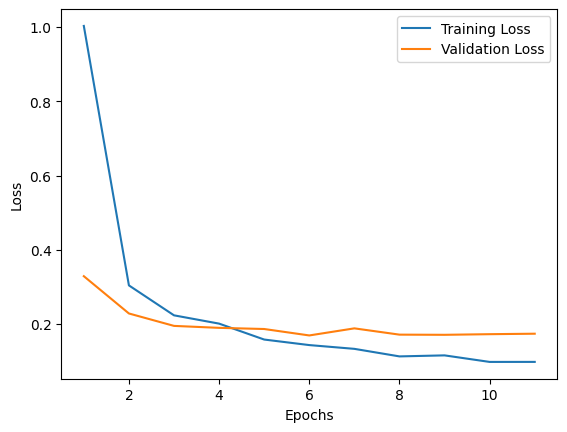

In [28]:
loaders_transfer = dataloaders
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, scheduler_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

In [29]:
test(loaders_transfer, model_transfer[0], criterion_transfer, use_cuda)

Test Loss: 0.051856


Test Accuracy: 98% (743/751)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]


Epoch: 1 	Training Loss: 2.037108 	Validation Loss: 1.149823
Validation Loss decreased! Model saved.
Epoch: 2 	Training Loss: 2.120529 	Validation Loss: 1.121038
Validation Loss decreased! Model saved.
Epoch: 3 	Training Loss: 2.580302 	Validation Loss: 1.238447
Epoch: 4 	Training Loss: 2.351843 	Validation Loss: 1.536209
Epoch: 5 	Training Loss: 2.257110 	Validation Loss: 1.136394
Epoch: 6 	Training Loss: 2.040299 	Validation Loss: 1.082496
Validation Loss decreased! Model saved.
Epoch: 7 	Training Loss: 2.402592 	Validation Loss: 1.014620
Validation Loss decreased! Model saved.
Epoch: 8 	Training Loss: 1.632971 	Validation Loss: 0.968354
Validation Loss decreased! Model saved.
Epoch: 9 	Training Loss: 1.693582 	Validation Loss: 0.891196
Validation Loss decreased! Model saved.
Epoch: 10 	Training Loss: 1.639179 	Validation Loss: 1.032992
Epoch: 11 	Training Loss: 1.867811 	Validation Loss: 0.947864
Training complete in 14m 14s


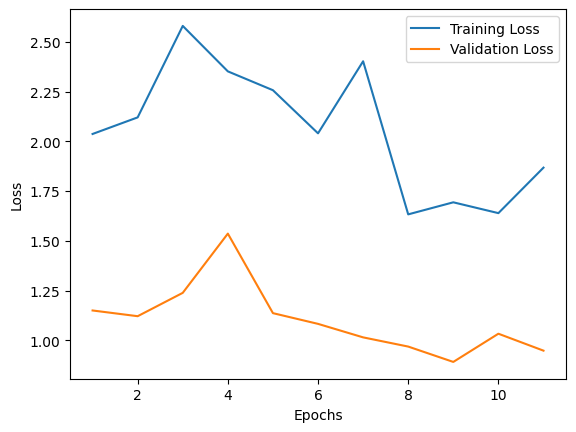

In [30]:
model_transfer2 = models.vgg16(pretrained=True)

classifier_features = list(model_transfer2.classifier.children())[:-1]
classifier_features.extend([nn.Linear(4096, n_classes)])

model_transfer2.classifier = nn.Sequential(*classifier_features)

if use_cuda:
    model_transfer2.cuda()

criterion_transfer2 = nn.CrossEntropyLoss()
optimizer_transfer2 = optim.Adam(model_transfer2.classifier.parameters(), lr=learning_rate, betas=(momentum, 0.999))
scheduler_transfer2 = ReduceLROnPlateau(optimizer_transfer2, mode='min', patience=5, factor=0.1, verbose=True)

model_transfer2 = train(n_epochs, dataloaders, model_transfer2, optimizer_transfer2, scheduler_transfer2, criterion_transfer2, use_cuda, 'model_transfer2.pt')

In [31]:
test(dataloaders, model_transfer2[0], criterion_transfer2, use_cuda)

Test Loss: 0.320349


Test Accuracy: 92% (691/751)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s] 


Epoch: 1 	Training Loss: 1.009103 	Validation Loss: 0.311308
Validation Loss decreased! Model saved.
Epoch: 2 	Training Loss: 0.368635 	Validation Loss: 0.222407
Validation Loss decreased! Model saved.
Epoch: 3 	Training Loss: 0.313073 	Validation Loss: 0.228243
Epoch: 4 	Training Loss: 0.278192 	Validation Loss: 0.252707
Epoch: 5 	Training Loss: 0.265243 	Validation Loss: 0.243074
Epoch: 6 	Training Loss: 0.224889 	Validation Loss: 0.213632
Validation Loss decreased! Model saved.
Epoch: 7 	Training Loss: 0.216327 	Validation Loss: 0.211963
Validation Loss decreased! Model saved.
Epoch: 8 	Training Loss: 0.212390 	Validation Loss: 0.301979
Epoch: 9 	Training Loss: 0.206341 	Validation Loss: 0.250477
Epoch: 10 	Training Loss: 0.209337 	Validation Loss: 0.248192
Epoch: 11 	Training Loss: 0.201856 	Validation Loss: 0.212967
Training complete in 5m 27s


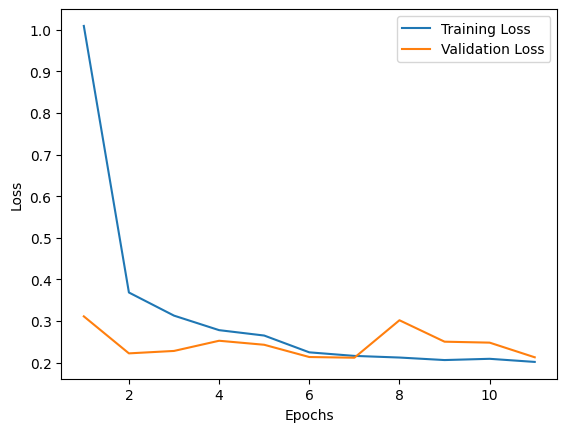

In [32]:
model_transfer3 = models.resnet50(pretrained=True)
for param in model_transfer3.parameters():
    param.requires_grad = False
num_ftrs3 = model_transfer3.fc.in_features
model_transfer3.fc = nn.Linear(num_ftrs3, n_classes)

if use_cuda:
    model_transfer3.cuda()

criterion_transfer3 = nn.CrossEntropyLoss()
optimizer_transfer3 = optim.Adam(model_transfer3.fc.parameters(), lr=learning_rate, betas=(momentum, 0.999))
scheduler_transfer3 = ReduceLROnPlateau(optimizer_transfer3, mode='min', patience=5, factor=0.1, verbose=True)

model_transfer3 = train(n_epochs, dataloaders, model_transfer3, optimizer_transfer3,scheduler_transfer3, criterion_transfer3, use_cuda, 'model_transfer3.pt')

In [33]:
test(dataloaders, model_transfer3[0], criterion_transfer3, use_cuda)

Test Loss: 0.065597


Test Accuracy: 98% (739/751)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.2MB/s]


Epoch: 1 	Training Loss: 0.622831 	Validation Loss: 0.287729
Validation Loss decreased! Model saved.
Epoch: 2 	Training Loss: 0.340507 	Validation Loss: 0.235595
Validation Loss decreased! Model saved.
Epoch: 3 	Training Loss: 0.304352 	Validation Loss: 0.269848
Epoch: 4 	Training Loss: 0.265511 	Validation Loss: 0.249181
Epoch: 5 	Training Loss: 0.273567 	Validation Loss: 0.260928
Epoch: 6 	Training Loss: 0.258218 	Validation Loss: 0.244478
Epoch: 7 	Training Loss: 0.236372 	Validation Loss: 0.260290
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 8 	Training Loss: 0.229443 	Validation Loss: 0.244675
Epoch: 9 	Training Loss: 0.206401 	Validation Loss: 0.232714
Validation Loss decreased! Model saved.
Epoch: 10 	Training Loss: 0.177577 	Validation Loss: 0.232902
Epoch: 11 	Training Loss: 0.161947 	Validation Loss: 0.262136
Training complete in 6m 53s


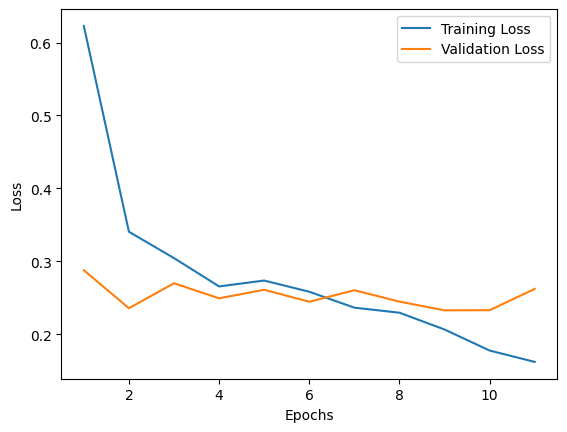

In [34]:
model_transfer4 = models.vgg19(pretrained=True)
for param in model_transfer4.parameters():
    param.requires_grad = False
num_ftrs5 = model_transfer4.classifier[6].in_features
model_transfer4.classifier[6] = nn.Linear(num_ftrs5, n_classes)

if use_cuda:
    model_transfer4.cuda()

criterion_transfer4 = nn.CrossEntropyLoss()
optimizer_transfer4 = optim.Adam(model_transfer4.classifier.parameters(), lr=learning_rate, betas=(momentum, 0.999))
scheduler_transfer4 = ReduceLROnPlateau(optimizer_transfer4, mode='min', patience=5, factor=0.1, verbose=True)

model_transfer4 = train(n_epochs, dataloaders, model_transfer4, optimizer_transfer4, scheduler_transfer4, criterion_transfer4, use_cuda, 'model_transfer4.pt')

In [35]:
test(dataloaders, model_transfer4[0], criterion_transfer4, use_cuda)

Test Loss: 0.084860


Test Accuracy: 97% (729/751)
